In [4]:
import pandas as pd
import numpy as np
import numpy.typing as npt
from typing import List
import matplotlib.pyplot as plt
import sys
import copy
import warnings
import statsmodels
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tools.eval_measures import bic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
from stargazer import stargazer

In [5]:
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }

In [6]:
data = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment1/DA3-phdma/HM1/morg-2014-emp.csv")
data.head()
#Data imported correctly since we have 149316 observations

/var/folders/6t/d3d0rh5d1rd426bk9g_mnhd00000gn/T/ipykernel_98998/920692788.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


We will keep only workers in the cathegory: Editors. 
The Census Code is: 2830

In [7]:
# CLEANING AND CREATION OF NEW VARIABLE

data = data[(data['occ2012'] == 2830)]
summary = data.describe()
summary_code = data['occ2012'].describe()
summary1 = data['lfsr94'].describe()

# create the variable
data['w'] = data['earnwke'] / data['uhours']
data['lnw'] = np.log(data['w'])
data['agesqr'] = data['age']**2
data = data[data['lfsr94'] == "Employed-At Work"]
data['sex'] = data['sex'].astype(np.int)

# Assuming 'data' is your DataFrame
data['grade92'] = data['grade92'].replace({34: 39, 33: 39, 39: 39, 36: 39, 40: 44, 41: 44, 42: 44, 43: 44, 44: 44, 46: 44})

print(data.dtypes)
summary_code = data['occ2012'].describe()
summary1 = data['lfsr94'].describe()

Unnamed: 0      int64
hhid            int64
intmonth       object
stfips         object
weight        float64
earnwke       float64
uhours          int64
grade92         int64
race            int64
ethnic        float64
age             int64
sex             int64
marital         int64
ownchild        int64
chldpres        int64
prcitshp       object
state          object
ind02          object
occ2012         int64
class          object
unionmme       object
unioncov       object
lfsr94         object
w             float64
lnw           float64
agesqr          int64
dtype: object


/var/folders/6t/d3d0rh5d1rd426bk9g_mnhd00000gn/T/ipykernel_98998/1138530575.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
# create a new var which create a list of values for each state
states = sorted(data['stfips'].unique())
state_code = {state: code for code, state in enumerate(states, start=1)}
data['state_code'] = data['stfips'].map(state_code)

# Getting some insights regarding the dataset
columns_of_interest = ['earnwke', 'uhours', 'w', 'agesqr'] 
specific_columns_stats = data[columns_of_interest].describe()


print(specific_columns_stats)
print(state_code)
print(data.isnull().sum())
data['sex'].value_counts()

           earnwke      uhours           w       agesqr
count   152.000000  152.000000  152.000000   152.000000
mean   1099.228355   38.611842   28.665901  1735.223684
std     654.002655    9.550874   19.121826  1020.689464
min      30.000000    4.000000    2.692000   256.000000
25%     694.800000   40.000000   17.734937   841.000000
50%     961.530000   40.000000   24.719500  1521.000000
75%    1442.300000   40.000000   34.973682  2425.750000
max    2884.610000   60.000000  171.794667  4096.000000
{'CA': 1, 'CO': 2, 'CT': 3, 'DC': 4, 'DE': 5, 'FL': 6, 'GA': 7, 'HI': 8, 'IA': 9, 'ID': 10, 'IL': 11, 'IN': 12, 'KS': 13, 'LA': 14, 'MA': 15, 'MD': 16, 'ME': 17, 'MI': 18, 'MN': 19, 'MO': 20, 'MS': 21, 'MT': 22, 'ND': 23, 'NE': 24, 'NH': 25, 'NJ': 26, 'NM': 27, 'NV': 28, 'NY': 29, 'OH': 30, 'OR': 31, 'PA': 32, 'SC': 33, 'TN': 34, 'TX': 35, 'UT': 36, 'VA': 37, 'VT': 38, 'WA': 39, 'WI': 40, 'WY': 41}
Unnamed: 0      0
hhid            0
intmonth        0
stfips          0
weight          0
earn

1    77
2    75
Name: sex, dtype: int64


Now we have:
1) chosen a working category which, in this case, is 2830, "Editors".
2) Cleaned and organized the dataset
    2.1) in the two graph we can see how there a different distribution of wages between female and male.
3) we extrapplate some insight from the dataset, which from the original 149316 observations, now has 152.
4) We are able to visualize data using python libraries such as matplotlib and seaborn.
5) check for the kurtuosis and the values if it's high maybe there are outliers values.

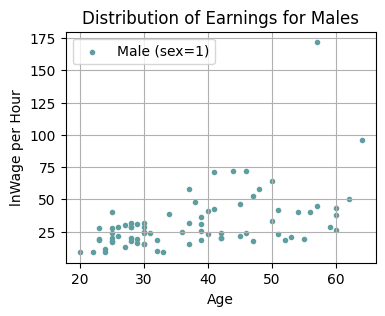

In [9]:
data_male = data[data['sex'] == 1]

plt.figure(figsize=(4, 3))
plt.scatter(data_male['age'], data_male['w'], color='cadetblue', marker='.', label='Male (sex=1)')
plt.title('Distribution of Earnings for Males')
plt.xlabel('Age')
plt.ylabel('lnWage per Hour')
plt.legend()
plt.grid(True)
plt.show()

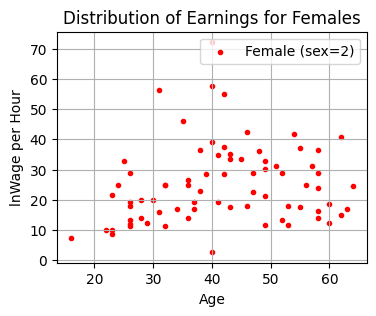

In [11]:
data_female = data[data['sex'] == 2]
plt.figure(figsize=(4, 3))
plt.scatter(data_female['age'], data_female['w'], color='red', marker='.', label='Female (sex=2)')
plt.title('Distribution of Earnings for Females')
plt.xlabel('Age')
plt.ylabel('lnWage per Hour')
plt.legend()
plt.grid(True)
plt.show()

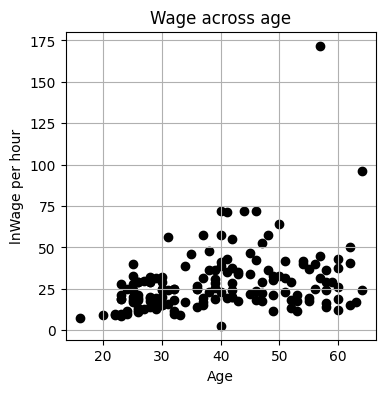

In [12]:
plt.figure(figsize=(4, 4))
plt.scatter(data['age'], data['w'], color='black')
plt.title("Wage across age")
plt.xlabel("Age")
plt.ylabel("lnWage per hour")
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


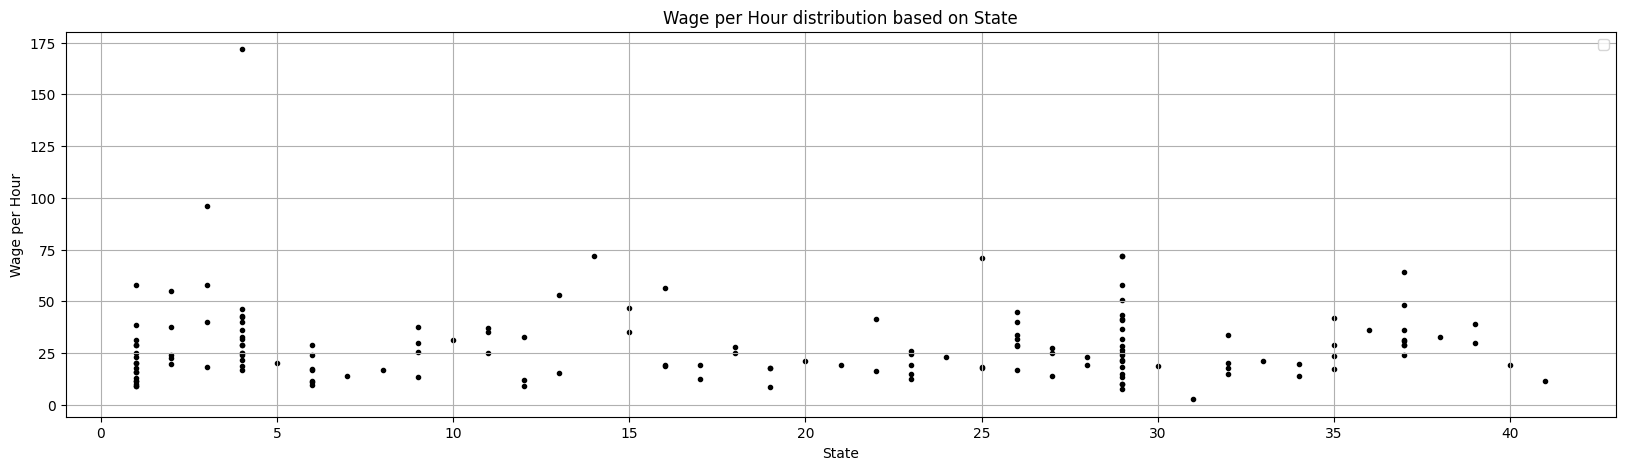

In [13]:
plt.figure(figsize=(20, 5))
plt.scatter(data['state_code'], data['w'], color='black', marker='.')
plt.title("Wage per Hour distribution based on State")
plt.xlabel('State')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()

Right now we will work on the model selection. We will run 4 models in which we take into consideration variables such as: age, agesqr, sex, ownchild, grade92.
What we are interested in predict is the wage per hour which is defined as "w". 

In [14]:
from stargazer.stargazer import Stargazer, LineLocation
mod1 = smf.ols("lnw ~ age + agesqr + sex + C(grade92)", data=data).fit(cov_type="HC1")
mod2 = smf.ols("lnw ~ age + agesqr + sex + C(grade92) + C(race)", data=data).fit(cov_type="HC1")
mod3 = smf.ols("lnw ~ age + agesqr + sex + C(grade92) + C(race) + C(unionmme)", data=data).fit(cov_type="HC1")
mod4 = smf.ols("lnw ~ age + agesqr + sex + C(grade92) + C(race) + C(unionmme) + state_code", data=data).fit(cov_type="HC1")

models = [mod1, mod2, mod3, mod4]
bic_values = [model.bic for model in models]
starg = Stargazer(models)
starg.covariate_order(["age", "agesqr", "sex"])
    
starg.add_line("BIC", [f'{bic:.0f}' for bic in bic_values], LineLocation.FOOTER_BOTTOM) 
starg

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 9


In [15]:
for i, model in enumerate(models, start=1):
    result = model.get_robustcov_results(cov_type='HC1')
    print(f"BIC for model {i}: {result.bic}")

BIC for model 1: 234.43652596301212
BIC for model 2: 243.82350474807475
BIC for model 3: 247.64752986627207
BIC for model 4: 252.6713678632688


In [16]:
from sklearn.metrics import mean_squared_error
for i, model in enumerate(models):
    # Assuming 'w' is the dependent variable in your regression
    y_pred = model.predict(data)
    rmse_value = np.sqrt(mean_squared_error(data['w'], y_pred))
    print(f"RMSE for Model {i + 1}: {rmse_value}")

RMSE for Model 1: 31.74072207019933
RMSE for Model 2: 31.723855965115423
RMSE for Model 3: 31.723295372149448
RMSE for Model 4: 31.72330188779899


In [17]:


def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator

    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    Returns
    -------
    dict
        Dictionary containing RMSE, R-squared, BIC, No. coefficients, Training RMSE,
        and Test RMSE.

    """

    # Get dependent variable
    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data
    model = smf.ols(formula, data=data).fit()
    rsquared = model.rsquared
    n_coefficients = model.df_model + 1
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold
    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }

result = ols_crossvalidator("lnw ~ age + agesqr + sex + C(grade92) + C(unionmme) + state_code", data, n_folds=4)
print(result)

{'RMSE': 0.4783706519277472, 'R-squared': 0.26520834366151025, 'BIC': 242.36417268230917, 'Coefficients': 7.0, 'Training RMSE': 0.4758026384444346, 'Test RMSE': 0.4940994627060795}


##Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


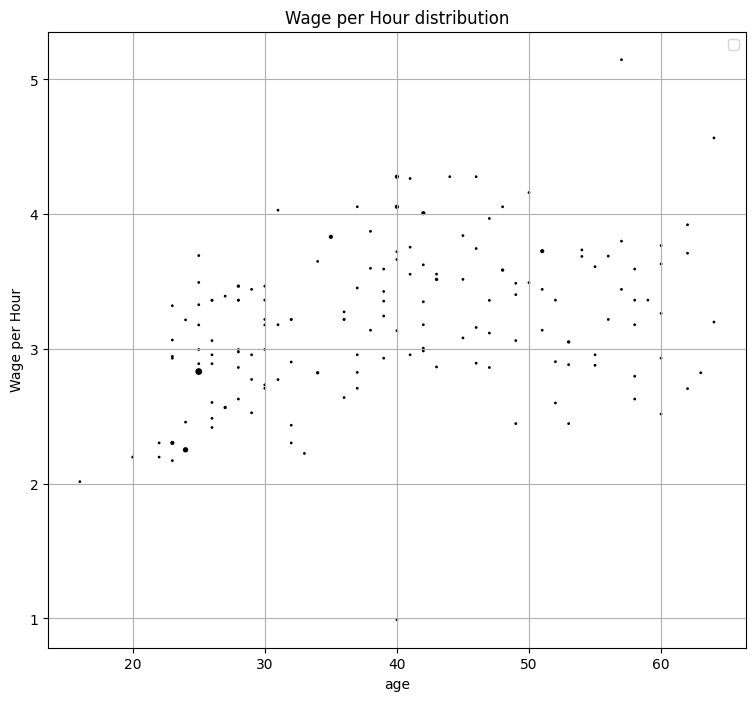

In [18]:
plt.figure(figsize=(9, 8))
plt.scatter(data['age'], data['lnw'], data["race"], color='black')
plt.title("Wage per Hour distribution")
plt.xlabel('age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()